# Informed Search
> In this final chapter you will be given a taste of more advanced hyperparameter tuning methodologies known as ''informed search''. This includes a methodology known as Coarse To Fine as well as Bayesian & Genetic hyperparameter tuning algorithms. You will learn how informed search differs from uninformed search and gain practical skills with each of the mentioned methodologies, comparing and contrasting them as you go. This is the Summary of lecture "Hyperparameter Tuning in Python", via datacamp.

- toc: true 
- badges: true
- comments: true
- author: Chanseok Kang
- categories: [Python, Datacamp, Machine_Learning]
- image: images/acc_for_lr.png

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Informed Search - Coarse to Fine
- Coarse to fine tuning
    1. Random search
    2. Find promising areas
    3. Grid search in the smaller area
    4. Continue until optimal score obtained
- Why Coarse to Fine?
    - Utilizes the advantanges of grid and random search
        - Wide search to begin with
        - Deeper search once you know where a good spot is likely to be
    - Better spending of time and computational efforts mean you can iterate quicker
    

### Visualizing Coarse to Fine
You're going to undertake the first part of a Coarse to Fine search. This involves analyzing the results of an initial random search that took place over a large search space, then deciding what would be the next logical step to make your hyperparameter search finer.

In [2]:
def visualize_hyperparameter(name):
    plt.clf()
    plt.scatter(results_df[name],results_df['accuracy'], c=['blue']*500)
    plt.gca().set(xlabel='{}'.format(name), ylabel='accuracy', title='Accuracy for different {}s'.format(name))
    plt.gca().set_ylim([0,100])

11000
    max_depth  min_samples_leaf  learn_rate  accuracy
1          10                14    0.477450        97
4           6                12    0.771275        97
2           7                14    0.050067        96
3           5                12    0.023356        96
5          13                11    0.290470        96
6           6                10    0.317181        96
7          19                10    0.757919        96
8           2                16    0.931544        96
9          16                13    0.904832        96
10         12                13    0.891477        96
Index(['max_depth', 'min_samples_leaf', 'learn_rate', 'accuracy'], dtype='object')


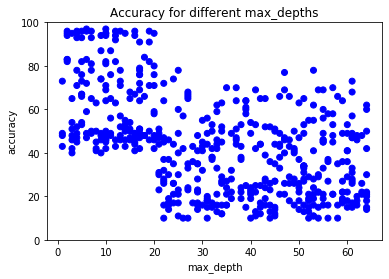

In [3]:
from itertools import product

max_depth_list = range(1, 6)
min_samples_leaf_list = range(3, 14)
learn_rate_list = np.linspace(0.01, 1.33, 200)

combinations_list = [list(x) for x in product(max_depth_list, 
                                              min_samples_leaf_list, 
                                              learn_rate_list)]

results_df = pd.read_csv('./dataset/results_df.csv')

# Confirm the size fo the combinations_list
print(len(combinations_list))

# Sort the results_df by accuracy and print the top 10 rows
print(results_df.sort_values(by='accuracy', ascending=False).head(10))

# Confirm which hyperparameters were used in this search
print(results_df.columns)

# Call visualize_hyperparameter() with each hyperparameter in turn
visualize_hyperparameter('max_depth')

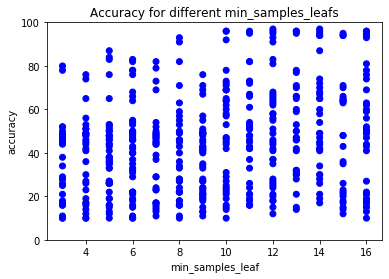

In [4]:
visualize_hyperparameter('min_samples_leaf')

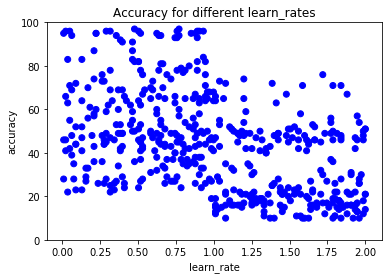

In [5]:
visualize_hyperparameter('learn_rate')

We have undertaken the first step of a Coarse to Fine search. Results clearly seem better when `max_depth` is below 20. learn_rates smaller than 1 seem to perform well too. There is not a strong trend for `min_samples` leaf though.

### Coarse to Fine Iterations
You will now visualize the first random search undertaken, construct a tighter grid and check the results.

In [6]:
def visualize_first():
    for name in results_df.columns[0:2]:
        plt.clf()
        plt.scatter(results_df[name],results_df['accuracy'], c=['blue']*500)
        plt.gca().set(xlabel='{}'.format(name), ylabel='accuracy', title='Accuracy for different {}s'.format(name))
        plt.gca().set_ylim([0,100])
        x_line = 20
        if name == "learn_rate":
            x_line = 1
        plt.axvline(x=x_line, color="red", linewidth=4)

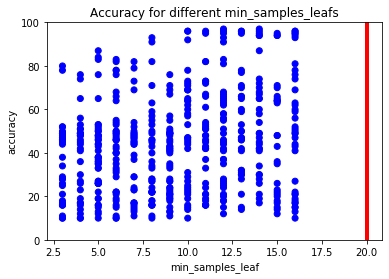

In [7]:
# Use the provided function to visualize the first results
visualize_first()

In [9]:
def visualize_second():
    for name in results_df2.columns[0:2]:
        plt.clf()
        plt.scatter(results_df[name],results_df['accuracy'], c=['blue']*500)
        plt.gca().set(xlabel='{}'.format(name), ylabel='accuracy', title='Accuracy for different {}s'.format(name))
        plt.gca().set_ylim([0,100])
        x_line = 20
        if name == "learn_rate":
            x_line = 1
        plt.axvline(x=x_line, color="red", linewidth=4)

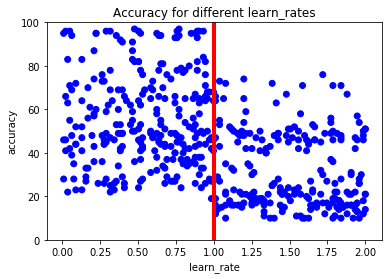

In [10]:
# Create some combination lists & combine
max_depth_list = list(range(1, 21))
learn_rate_list = np.linspace(0.001, 1, 50)

results_df2 = pd.read_csv('./dataset/results_df2.csv')

visualize_second()

## Informed Search - Bayesian Statistics
- Bayes rule
    - A statistical method of using new evidence to iteratively update our beliefs about some outcome
$$ P(A \vert B) = \frac{P(B \vert A) P(A)}{P(B)} $$
    - LHS = the probability of A given B has occurred. B is some new evidence (**Posterior**)
    - RHS = how to calculate LHS
        - $P(A)$ is the **'prior'**. The initial hypothesis about the event. 
        - $P(A\vert B)$ is the probability given new evidence
        - $P(B)$ is the **'marginal likelihood'**. It is the probability of observing this new evidence
        - $P(B \vert A)$ is the **likelihood** which is the probability of observing the evidence, given the event we care about
- Bayes in Hyperparameter Tuning
    - Pick a hyperparameter combination
    - Build a model
    - Get new evidence (the score of the model)
    - Update our belief and chose better hyperparamters next round

### Bayes Rule in Python
In this exercise you will undertake a practical example of setting up Bayes formula, obtaining new evidence and updating your 'beliefs' in order to get a more accurate result. The example will relate to the likelihood that someone will close their account for your online software product.

These are the probabilities we know:

- 7% (0.07) of people are likely to close their account next month
- 15% (0.15) of people with accounts are unhappy with your product (you don't know who though!)
- 35% (0.35) of people who are likely to close their account are unhappy with your product

In [11]:
# Assign probabilities to variables
p_unhappy = 0.15
p_unhappy_close = 0.35

# Probability someone will close
p_close = 0.07

# Probability unhappy person will close
p_close_unhappy = (p_unhappy_close * p_close) / p_unhappy
print(p_close_unhappy)

0.16333333333333336


### Bayesian Hyperparameter tuning with Hyperopt
In this example you will set up and run a bayesian hyperparameter optimization process using the package `Hyperopt`. You will set up the domain (which is similar to setting up the grid for a grid search), then set up the objective function. Finally, you will run the optimizer over 20 iterations.

You will need to set up the domain using values:

- `max_depth` using quniform distribution (between 2 and 10, increasing by 2)
- `learning_rate` using uniform distribution (0.001 to 0.9)

Note that for the purpose of this exercise, this process was reduced in data sample size and hyperopt & GBM iterations. If you are trying out this method by yourself on your own machine, try a larger search space, more trials, more cvs and a larger dataset size to really see this in action!

> Note: This session requires `Hyperopt` packages

In [12]:
from sklearn.model_selection import train_test_split

credit_card = pd.read_csv('./dataset/credit-card-full.csv')
# To change categorical variable with dummy variables
credit_card = pd.get_dummies(credit_card, columns=['SEX', 'EDUCATION', 'MARRIAGE'], drop_first=True)

X = credit_card.drop(['ID', 'default payment next month'], axis=1)
y = credit_card['default payment next month']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True)

In [13]:
import hyperopt as hp
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score

# Set up space dictionary with specified hyperparamters
space = {'max_depth': hp.hp.quniform('max_depth', 2, 10, 2),
         'learning_rate': hp.hp.uniform('learning_rate', 0.001, 0.9)}

# Set up objective function
def objective(params):
    params = {'max_depth': int(params['max_depth']), 
              'learning_rate': params['learning_rate']}
    gbm_clf = GradientBoostingClassifier(n_estimators=100, **params)
    best_score = cross_val_score(gbm_clf, X_train, y_train, 
                                 scoring='accuracy', cv=2, n_jobs=4).mean()
    loss = 1 - best_score
    return loss

# Run the algorithm
best = hp.fmin(fn=objective, space=space, max_evals=20, 
               rstate=np.random.RandomState(42), algo=hp.tpe.suggest)
print(best)

100%|██████████| 20/20 [02:16<00:00,  6.83s/trial, best loss: 0.18080952380952375]
{'learning_rate': 0.0128515490384306, 'max_depth': 6.0}


## Informed Search - Genetic Algorithms
- Genetics in Machine Learning
    1. Create some models (that have hyperparameter settings)
    2. Pick the best (by our scoring function)
    : these are the ones that "survive"
    3. Create new models that are similar to the best ones
    4. Add in some randomness so we don't reach a local optimum
    5. Repeat until we are happy!
- Advantages
    - It allows us to learn from previous iterations, just like bayesian hyperparameter tuning
    - It has the additional advantage of some randomness
    - Takes care of many tedious aspects of machine learning

### Genetic Hyperparameter Tuning with TPOT
You're going to undertake a simple example of genetic hyperparameter tuning. `TPOT` is a very powerful library that has a lot of features. You're just scratching the surface in this lesson, but you are highly encouraged to explore in your own time.

This is a very small example. In real life, TPOT is designed to be run for many hours to find the best model. You would have a much larger population and offspring size as well as hundreds more generations to find a good model.

You will create the estimator, fit the estimator to the training data and then score this on the test data.

For this example we wish to use:

- 3 generations
- 4 in the population size
- 3 offspring in each generation
- `accuracy` for scoring

> Note: This session requires `tpot` packages

In [14]:
from tpot import TPOTClassifier

# Assign the values outlined to the inputs
number_generations = 3
population_size = 4
offspring_size = 3
scoring_function = 'accuracy'

# Create the tpot classifier
tpot_clf = TPOTClassifier(generations=number_generations, population_size=population_size,
                          offspring_size=offspring_size, scoring=scoring_function,
                          verbosity=2, random_state=2, cv=2)

# Fit the classifier to the training data
tpot_clf.fit(X_train, y_train)

# Score on the test set
print(tpot_clf.score(X_test, y_test))


Generation 1 - Current best internal CV score: 0.8204285714285714
Generation 2 - Current best internal CV score: 0.8204285714285714
Generation 3 - Current best internal CV score: 0.8204285714285714
Best pipeline: DecisionTreeClassifier(input_matrix, criterion=gini, max_depth=1, min_samples_leaf=10, min_samples_split=9)
0.8176666666666667


You can see in the output the score produced by the chosen model (in this case a version of Naive Bayes) over each generation, and then the final accuracy score with the hyperparameters chosen for the final model. This is a great first example of using TPOT for automated hyperparameter tuning.

### Analysing TPOT's stability
You will now see the random nature of TPOT by constructing the classifier with different random states and seeing what model is found to be best by the algorithm. This assists to see that TPOT is quite unstable when not run for a reasonable amount of time.



In [15]:
# Create the tpot classifier
tpot_clf = TPOTClassifier(generations=2, population_size=4, offspring_size=3,
                          scoring='accuracy', cv=2, verbosity=2, random_state=42)

# Fit the classifier to the training data
tpot_clf.fit(X_train, y_train)

# Score on the test set
print(tpot_clf.score(X_test, y_test))


Generation 1 - Current best internal CV score: 0.8213809523809524
Generation 2 - Current best internal CV score: 0.8213809523809524
Best pipeline: XGBClassifier(input_matrix, learning_rate=0.001, max_depth=9, min_child_weight=7, n_estimators=100, nthread=1, subsample=0.45)
0.8195555555555556


In [16]:
# Create the tpot classifier
tpot_clf = TPOTClassifier(generations=2, population_size=4, offspring_size=3,
                          scoring='accuracy', cv=2, verbosity=2, random_state=122)

# Fit the classifier to the training data
tpot_clf.fit(X_train, y_train)

# Score on the test set
print(tpot_clf.score(X_test, y_test))


Generation 1 - Current best internal CV score: 0.7811904761904762
Generation 2 - Current best internal CV score: 0.7811904761904762
Best pipeline: LogisticRegression(input_matrix, C=0.5, dual=False, penalty=l2)
0.7724444444444445


In [17]:
# Create the tpot classifier
tpot_clf = TPOTClassifier(generations=2, population_size=4, offspring_size=3,
                          scoring='accuracy', cv=2, verbosity=2, random_state=99)

# Fit the classifier to the training data
tpot_clf.fit(X_train, y_train)

# Score on the test set
print(tpot_clf.score(X_test, y_test))


Generation 1 - Current best internal CV score: 0.7960476190476191
Generation 2 - Current best internal CV score: 0.8049523809523809
Best pipeline: GradientBoostingClassifier(input_matrix, learning_rate=0.5, max_depth=3, max_features=0.6000000000000001, min_samples_leaf=15, min_samples_split=17, n_estimators=100, subsample=0.6000000000000001)
0.812


You can see that TPOT is quite unstable when only running with low generations, population size and offspring. The first model chosen was a Decision Tree, then a K-nearest Neighbor model and finally a Random Forest. Increasing the generations, population size and offspring and running this for a long time will assist to produce better models and more stable results.